In [1]:
# coding: utf-8
#Chargement des données
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pylab import *
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats.mstats import mode
from sklearn.utils import shuffle
from numpy import array
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
train=list()
test=list()
def unpickle(file):
	import cPickle
	fo = open(file, 'rb')
	dict = cPickle.load(fo)
	fo.close()
	return dict 

images = [[] for i in range(6)]
images[0] = unpickle('./cifar-10-batches-py/data_batch_1')
images[1] = unpickle('./cifar-10-batches-py/data_batch_2')
images[2] = unpickle('./cifar-10-batches-py/data_batch_3')
images[3] = unpickle('./cifar-10-batches-py/data_batch_4')
images[4] = unpickle('./cifar-10-batches-py/data_batch_5')
images[5] = unpickle('./cifar-10-batches-py/test_batch') 

train_set = [[] for i in range(5)]
train_label = [[] for i in range(5)]
test_set=[]
test_label=[]
train_set[0]=images[0]["data"]
train_label[0]=images[0]["labels"]
train_set[1]=images[1]["data"]
train_label[1]=images[1]["labels"]
train_set[2]=images[2]["data"]
train_label[2]=images[2]["labels"]
train_set[3]=images[3]["data"]
train_label[3]=images[3]["labels"]
train_set[4]=images[4]["data"]
train_label[4]=images[4]["labels"]
test_set=images[5]["data"]
test_label=images[5]["labels"]

In [2]:
################divisez l’image en 4 patches 
def quatre_patchs(image):
	ens = []	
	new_ens = []
	for i in image:	           #pour chaque images dans batchs
		rouge = i[0:1024]      
		vert  = i[1024:2048]
		bleu  = i[2048:3072]
		pixel = np.dstack((rouge,vert))
		pixel = np.dstack((pixel,bleu))
		pixel_n = pixel[0]
		pixel_n = np.reshape(pixel_n,(32,32,3))

		ens.append(pixel_n)
	for e in ens: 
        	new_ens.append(e[:16,:16])		#en haut à gauche 16 * 16 
       		new_ens.append(e[:16,16:])		#en haut à droite 
        	new_ens.append(e[16:,:16])		#en bas à gauche  
        	new_ens.append(e[16:,16:])		#en bas à droite  
	#return (len(new_ens))
	return array(new_ens) 
train_patch = [[] for i in range(5)]
test_patch=[]
train_patch[0]=quatre_patchs(train_set[0])
train_patch[1]=quatre_patchs(train_set[1])
train_patch[2]=quatre_patchs(train_set[2])
train_patch[3]=quatre_patchs(train_set[3])
train_patch[4]=quatre_patchs(train_set[4])
test_patch=quatre_patchs(test_set)

In [3]:
#explorez les donnes et changez les formes
print(len(train_patch[0]))
print(train_patch[0][0].shape)
#test_im = np.reshape(test_im,(len(test_im),768))
print(type(train_set[0]))
print(type(train_patch[0]))
x_train=np.concatenate((train_patch[0],train_patch[1],train_patch[2],train_patch[3],train_patch[4]),axis=0)
print(x_train.shape)
x_train=x_train.reshape(200000,768,)
print(x_train.shape)
print(train_patch[0][0].shape)
print(train_set[0][0].shape)
print(x_train[0].shape)
print(test_patch.shape)
x_test=test_patch.reshape(40000,768,)
print(x_test.shape)

40000
(16, 16, 3)
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(200000, 16, 16, 3)
(200000, 768)
(16, 16, 3)
(3072,)
(768,)
(40000, 16, 16, 3)
(40000, 768)


In [4]:
#whitening
print "whitening the train patches... "
[D,V]=np.linalg.eig(np.cov(x_train,rowvar=0))

P = V.dot(np.diag(np.sqrt(1/(D + 0.1)))).dot(V.T)
x_train = x_train.dot(P)
[D,V]=np.linalg.eig(np.cov(x_test,rowvar=0))

P = V.dot(np.diag(np.sqrt(1/(D + 0.1)))).dot(V.T)
x_test = x_test.dot(P)
print "end of whitening"

whitening the train patches... 
end of whitening


In [5]:
# Kmeans calcule les centres
from sklearn.cluster import KMeans 
K=60
print "Start creating the dictionary"
print "Start using the sklearn Kmeans...."
result = KMeans(n_clusters=K,max_iter=50).fit(x_train[0:120000])
print "K-means has done..."

Start creating the dictionary
Start using the sklearn Kmeans....
K-means has done...


In [6]:
center=result.cluster_centers_
print "center ",center.shape

center  (60, 768)


In [7]:
# changer les formes des donnes
res=np.zeros((200000,K))
for i in range(len(x_train)):
    s=np.linalg.norm(x_train[i]-center[0])
    index=0
    for j in range(len(center)):
        if np.linalg.norm(x_train[i]-center[j])<s:
            s=np.linalg.norm(x_train[i]-center[j])
            index=j
    res[i][index]=1
res_t=np.zeros((40000,K))
for i in range(len(x_test)):
    s=np.linalg.norm(x_test[i]-center[0])
    index=0
    for j in range(len(center)):
        if np.linalg.norm(x_test[i]-center[j])<s:
            s=np.linalg.norm(x_test[i]-center[j])
            index=j
    res_t[i][index]=1

#explorer les donnes
print(res[0])
print(len(res))
print(type(res[0]))
print(len(res_t[1]))
#r=res[0]+res[1]+res[2]
#print(r)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
200000
<type 'numpy.ndarray'>
60


In [8]:
# nonveaux donnes pour train et test
train_final=np.zeros((50000,4*K))
j=0
for i in range(len(train_final)):
    t1=np.append(res[j],res[j+1])
    t2=np.append(t1,res[j+2])
    train_final[i]=np.append(t2,res[j+3])
    j=j+4
test_final=np.zeros((10000,4*K))
j=0
for i in range(len(test_final)):
    t1=np.append(res_t[j],res_t[j+1])
    t2=np.append(t1,res_t[j+2])
    test_final[i]=np.append(t2,res_t[j+3])
    j=j+4

print(len(train_final[0]))
print(len(test_final[-1]))

240
240


In [9]:
# ontenir les donnes et les labels
y_train=np.concatenate((train_label[0],train_label[1],train_label[2],train_label[3],train_label[4]),axis=0)
y_test=test_label
print(y_train.shape)
print(train_final.shape)
train_set=train_final[0:20000]
train_label=y_train[0:20000]
test_set=test_final[0:5000]
test_label=y_test[0:5000]
#train=list()
#test=list()
print(len(train_set[0]))
print(train_label[0])

(50000,)
(50000, 240)
240
6


In [10]:
def dessine(s,t):
    y=list()
    j=72
    for i in range(10):
        y.append(float(s[j:j+4]))
        j=j+53
    #print(y)
    x = np.linspace(0,9,10)
    plt.figure(figsize=(10,5))
    plt.title(t)
    plt.ylim((0.1, 0.4))
    plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9],['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
    plt.plot(x, y,'rx',label='train')
    plt.show()


('decision tree:', [0.59755000000000003], [0.21560000000000001])
             precision    recall  f1-score   support

          0       0.24      0.42      0.31       488
          1       0.20      0.22      0.21       505
          2       0.19      0.19      0.19       512
          3       0.15      0.17      0.16       497
          4       0.23      0.21      0.22       507
          5       0.14      0.12      0.13       488
          6       0.21      0.16      0.18       491
          7       0.22      0.17      0.20       495
          8       0.34      0.37      0.35       504
          9       0.19      0.12      0.15       513

avg / total       0.21      0.22      0.21      5000



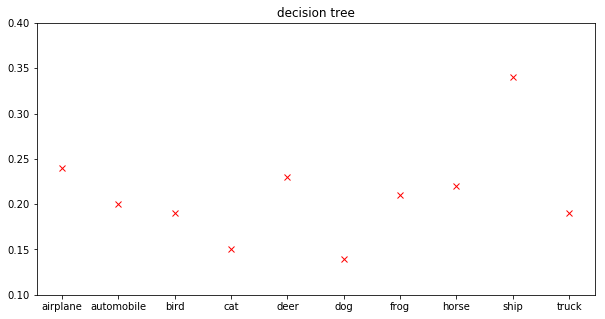

In [11]:
# decision tree
from sklearn import tree
#train_set=train_final[0:50000]
#train_label=y_train[0:50000]
#test_set=test_final[0:10000]
#test_label=y_test[0:10000]
train=list()
test=list()
clf = tree.DecisionTreeClassifier()
clf.fit(train_set,train_label) 
train.append(np.mean(clf.predict(train_set) == train_label))
test.append(np.mean(clf.predict(test_set) == test_label))
     
print("decision tree:",train,test) # affiche taux correct pour train_set et test_set
kl=clf.predict(test_set)
target_names = ['0','1', '2', '3','4','5','6','7','8','9']
print(classification_report(test_label, kl, target_names=target_names))
sl=classification_report(test_label, kl, target_names=target_names)
dessine(sl,"decision tree")

('Bayes: ', [0.21485000000000001], [0.21060000000000001])
             precision    recall  f1-score   support

          0       0.31      0.04      0.07       488
          1       0.28      0.27      0.28       505
          2       0.33      0.00      0.00       512
          3       0.21      0.02      0.03       497
          4       0.28      0.20      0.23       507
          5       0.18      0.36      0.24       488
          6       0.39      0.06      0.11       491
          7       0.19      0.43      0.27       495
          8       0.20      0.73      0.31       504
          9       0.43      0.01      0.01       513

avg / total       0.28      0.21      0.15      5000



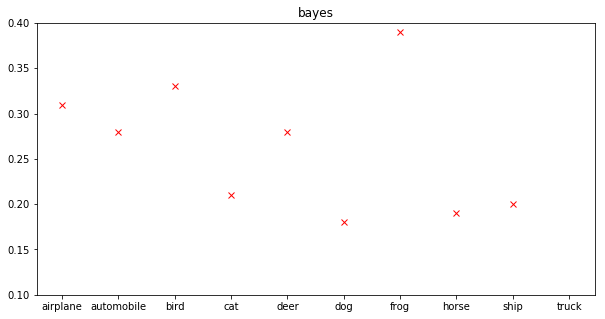

In [12]:

# bayes
from sklearn.naive_bayes import GaussianNB
train=list()
test=list()
clf = GaussianNB()
clf.fit(train_set,train_label) 
train.append(np.mean(clf.predict(train_set) == train_label))
test.append(np.mean(clf.predict(test_set) == test_label))

     
print("Bayes: ",train,test) 
kl=clf.predict(test_set)
target_names = ['0','1', '2', '3','4','5','6','7','8','9']
print(classification_report(test_label, kl, target_names=target_names))
sl=classification_report(test_label, kl, target_names=target_names)
dessine(sl,"bayes")

('perceptron:', [0.16985], [0.17100000000000001])
             precision    recall  f1-score   support

          0       0.23      0.06      0.09       488
          1       0.20      0.10      0.13       505
          2       0.13      0.08      0.10       512
          3       0.15      0.27      0.19       497
          4       0.16      0.02      0.04       507
          5       0.15      0.07      0.09       488
          6       0.18      0.09      0.12       491
          7       0.13      0.40      0.20       495
          8       0.23      0.61      0.34       504
          9       0.18      0.02      0.03       513

avg / total       0.17      0.17      0.13      5000



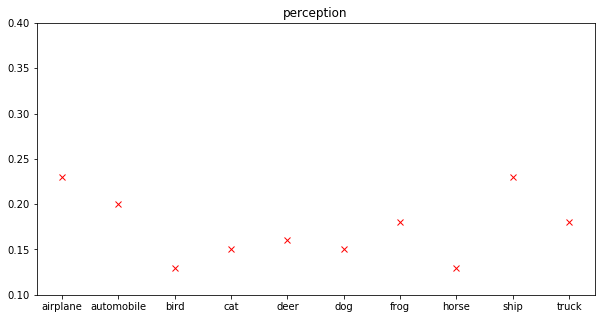

In [13]:
# Percetron rapide
from sklearn.linear_model import Perceptron
train=list()
test=list()
nt = Perceptron()  
nt.fit(train_set,train_label) 
train.append(np.mean(nt.predict(train_set) == train_label))
test.append(np.mean(nt.predict(test_set) == test_label))
print("perceptron:",train,test)
kl=nt.predict(test_set)
target_names = ['0','1', '2', '3','4','5','6','7','8','9']
print(classification_report(test_label, kl, target_names=target_names))
sl=classification_report(test_label, kl, target_names=target_names)
dessine(sl,"perception")

('SGDClassifier:', [0.20815], [0.20580000000000001])
             precision    recall  f1-score   support

          0       0.21      0.34      0.26       488
          1       0.28      0.23      0.26       505
          2       0.22      0.10      0.14       512
          3       0.12      0.01      0.03       497
          4       0.11      0.13      0.12       507
          5       0.18      0.27      0.21       488
          6       0.19      0.19      0.19       491
          7       0.18      0.30      0.23       495
          8       0.30      0.47      0.36       504
          9       0.15      0.03      0.04       513

avg / total       0.19      0.21      0.18      5000



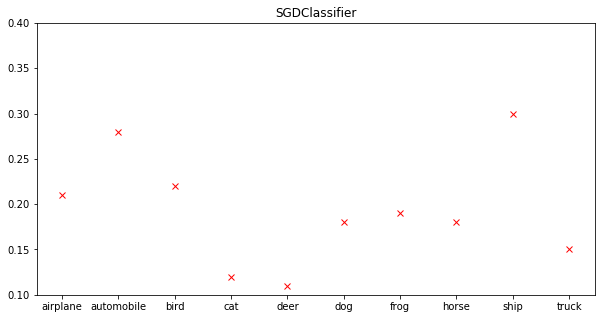

In [14]:
# SGDClassifier rapide
from sklearn.linear_model import SGDClassifier
train=list()
test=list()
nt = SGDClassifier()  
nt.fit(train_set,train_label) 
train.append(np.mean(nt.predict(train_set) == train_label))
test.append(np.mean(nt.predict(test_set) == test_label))
print("SGDClassifier:",train,test)
kl=nt.predict(test_set)
target_names = ['0','1', '2', '3','4','5','6','7','8','9']
print(classification_report(test_label, kl, target_names=target_names))
sl=classification_report(test_label, kl, target_names=target_names)
dessine(sl,"SGDClassifier")

('svc:', [0.26135000000000003], [0.2626])
             precision    recall  f1-score   support

          0       0.29      0.44      0.35       488
          1       0.27      0.31      0.29       505
          2       0.29      0.11      0.16       512
          3       0.17      0.40      0.24       497
          4       0.30      0.18      0.23       507
          5       0.25      0.15      0.19       488
          6       0.28      0.30      0.29       491
          7       0.28      0.25      0.26       495
          8       0.38      0.30      0.34       504
          9       0.28      0.18      0.22       513

avg / total       0.28      0.26      0.26      5000



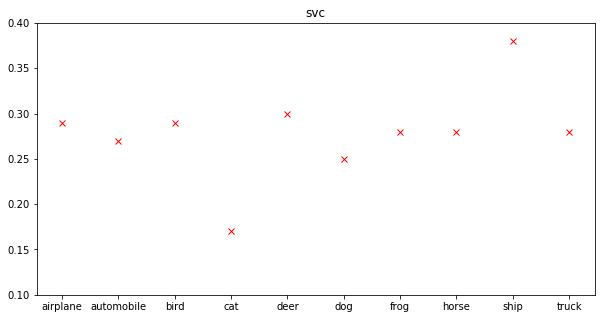

In [15]:
# naive SVC tres lent
from sklearn.svm import SVC
#train_set=train_final[0:5000]
#train_label=y_train[0:5000]
#test_set=test_final[0:1000]
#test_label=y_test[0:1000]
train=list()
test=list()
clf = SVC()
clf.fit(train_set,train_label) 
train.append(np.mean(clf.predict(train_set) == train_label))
test.append(np.mean(clf.predict(test_set) == test_label))
     
print("svc:" ,train,test) 
kl=clf.predict(test_set)
target_names = ['0','1', '2', '3','4','5','6','7','8','9']
print(classification_report(test_label, kl, target_names=target_names))
sl=classification_report(test_label, kl, target_names=target_names)
dessine(sl,"svc")

('kneighbor:', [0.39179999999999998], [0.20200000000000001])
             precision    recall  f1-score   support

          0       0.19      0.43      0.27       488
          1       0.18      0.25      0.21       505
          2       0.15      0.20      0.17       512
          3       0.16      0.18      0.17       497
          4       0.22      0.16      0.18       507
          5       0.20      0.11      0.14       488
          6       0.20      0.16      0.18       491
          7       0.24      0.13      0.17       495
          8       0.34      0.27      0.30       504
          9       0.24      0.14      0.18       513

avg / total       0.21      0.20      0.20      5000



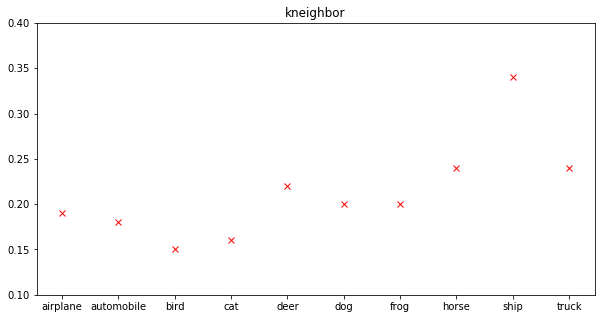

In [16]:
# kneighbor tres lent
from sklearn.neighbors import KNeighborsClassifier
#train_set=train_final[0:5000]
#train_label=y_train[0:5000]
#test_set=test_final[0:1000]
#test_label=y_test[0:1000]
train=list()
test=list()
nt = KNeighborsClassifier(n_neighbors=4)  
nt.fit(train_set,train_label) 
train.append(np.mean(nt.predict(train_set) == train_label))
test.append(np.mean(nt.predict(test_set) == test_label))
print("kneighbor:",train,test)
kl=nt.predict(test_set)
target_names = ['0','1', '2', '3','4','5','6','7','8','9']
print(classification_report(test_label, kl, target_names=target_names))
sl=classification_report(test_label, kl, target_names=target_names)
dessine(sl,"kneighbor")